## Neuron
Create spike raster from inhomogeneous Poisson processes, where the time-dependent rate is modelled as an OU process

In [1]:
using Pkg
Pkg.activate("../")
using CairoMakie
using Random
using Distributions
using StatsBase
using LinearAlgebra

  Activating project at `~/git/projects/perspective_heart_and_brain`


0.08080176064758494


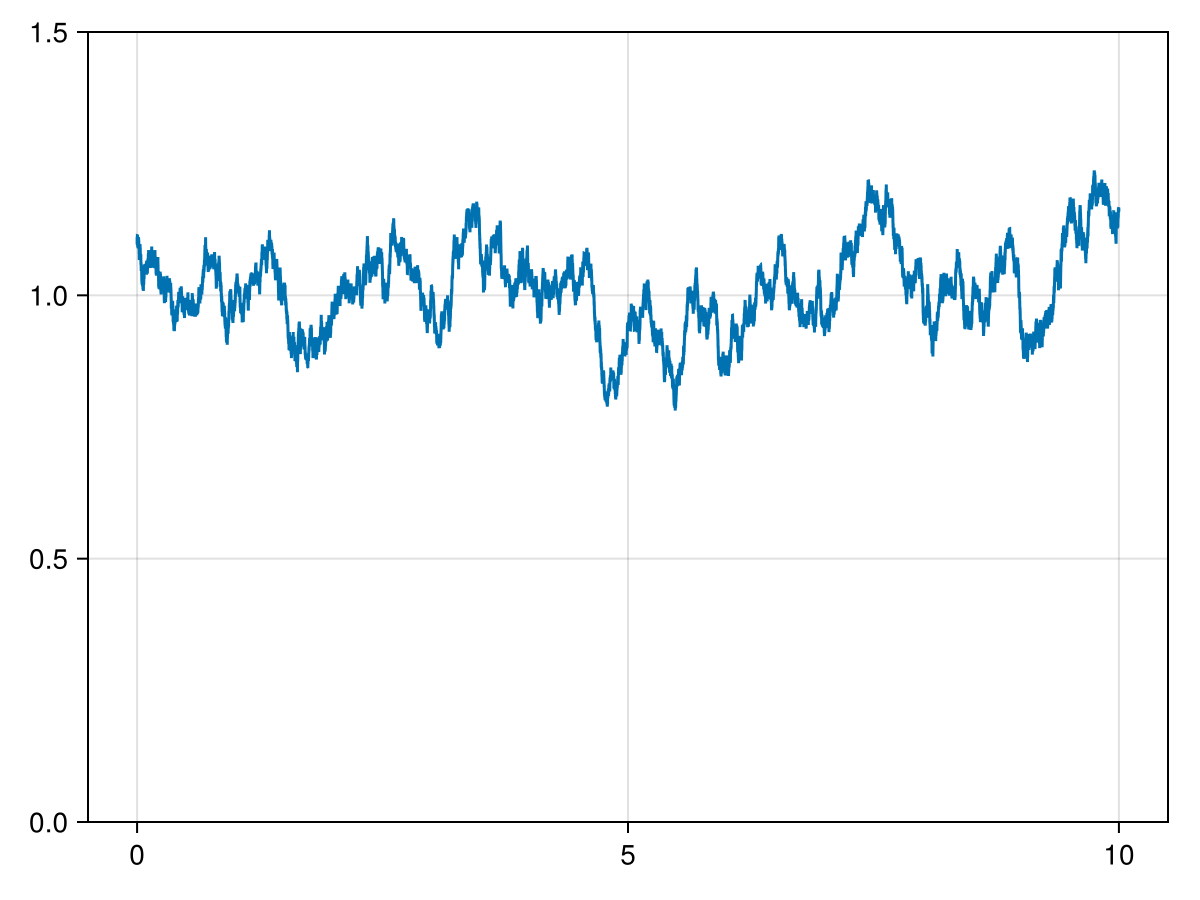

In [39]:
N = 100
# time-dependent rate of population
rate_μ = 1   # Hz
rate_σ = 0.1 # Hz
τ = 0.5   # s
dt = 1e-4 # s
t = 0:dt:50
# ornstein uhlenbeck process for the rate
rate = zeros(length(t))
rate[1] = rate_μ + rate_σ * randn()
for i in 2:length(rate)
    rate[i] = rate[i-1] + (rate_μ - rate[i-1]) * dt / τ + rate_σ * sqrt(2 * dt / τ) * randn()
end
# print std of rate
println(std(rate))
# quick plot to show the outcome
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, t, rate)
# y axis range
ylims!(ax, 0, 1.5)
fig

0.11200172601413849


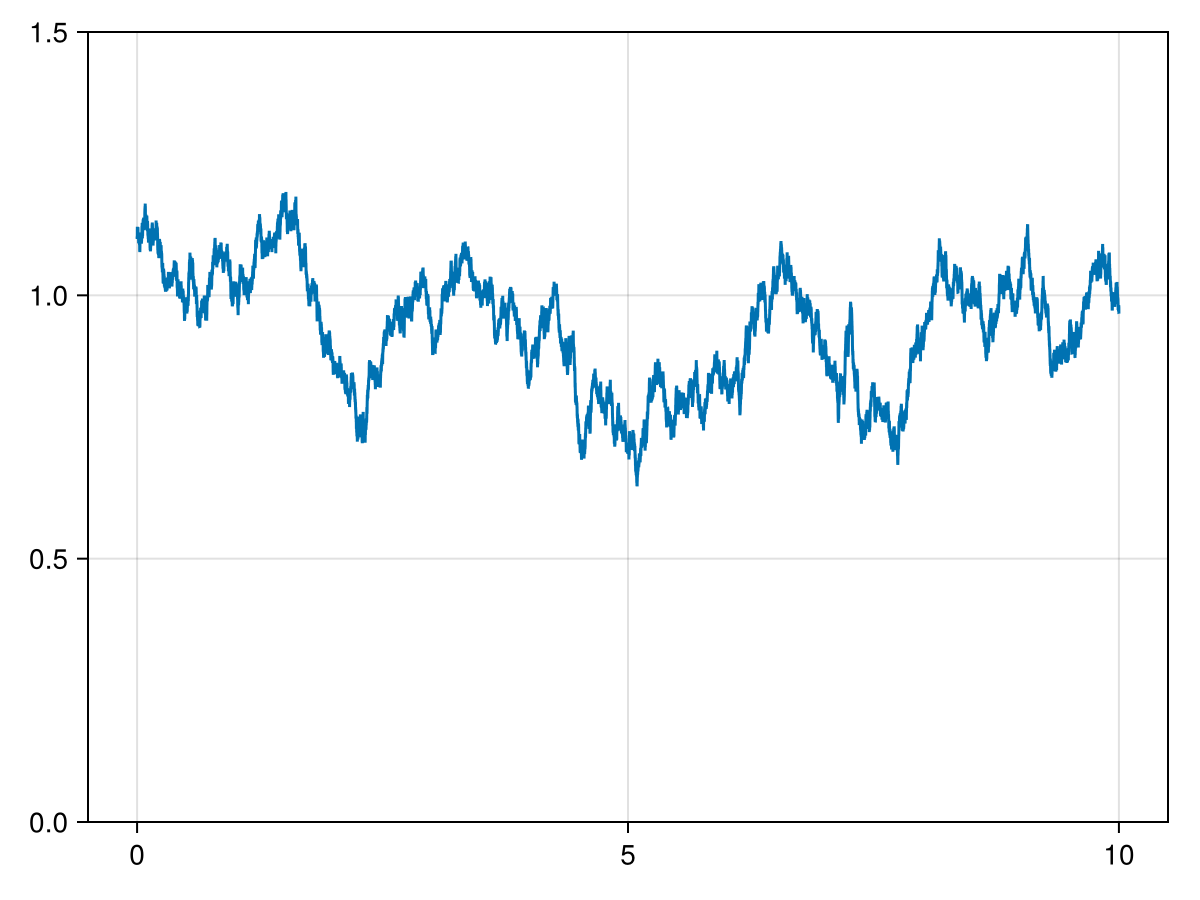

In [40]:
for i in 2:length(rate)
    rate[i] = rate[i-1] + (rate_μ - rate[i-1]) * dt / τ + rate_σ * sqrt(2 * dt / τ) * randn()
end
# print std of rate
println(std(rate))
# quick plot to show the outcome
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, t, rate)
# y axis range
ylims!(ax, 0, 1.5)
fig

In [41]:
# spike times as independent realizations of inhomogeneous Poisson process 
spikes = [ Float64[] for _ in 1:N]
# here, they all share the same population rate such that we can generate a single process with rate = r*N and assign each spike to a random neurons
rate_all = rate * N
rate_max = maximum(rate_all)
t_ = 0
# advance time with homogeneous poisson process at rate_max (i.e. exp. inter-event times)
dist_dt = Exponential(1/rate_max)
while t_ < t[end]
    #t_ += -log(rand()) / rate_max
    t_ += rand(dist_dt)
    # a spike happens at t_ with probability rate_all[findfirst(x -> x > t_, t)]/rate_max
    if t_ < t[end] && rand() < rate_all[findfirst(x -> x > t_, t)]/rate_max
        # choose random neuron to append this spike time
        push!(spikes[rand(1:N)], t_)
    end
end
spikes

100-element Vector{Vector{Float64}}:
 [1.0555914065296912, 1.5774877837914045, 1.9120677891736204, 6.537683480183089]
 [0.3614771380475821, 1.0449124348387473, 1.2508135683452046, 2.159105219703252, 3.6553751420154232, 3.7639100758818476, 4.117722112179868, 4.490905856424891, 5.458117642772562, 8.350468588819462, 9.756104584732851]
 [1.5901380507273124, 2.2609240840108322, 3.6634245078575165, 5.40521867099802, 7.544239197728656, 8.163335470765388, 8.947757999841352, 9.654926787309954]
 [0.014929136759664813, 0.16442922111481342, 0.2492853398331988, 0.9312203280199289, 1.910328407948927, 3.5760696460746697, 6.966390698859692, 8.296940509664381, 8.388721930087431, 8.72449880412993]
 [2.556216205331682, 3.819924723930919, 5.1574232376778975, 5.69550673939595, 7.614677315244387, 9.310104008297678, 9.598431257823366, 9.7658073018929]
 [0.6754782080282009, 1.289953284998174, 4.174410008113485, 4.642953391339914, 4.783495617625173, 4.895206845610446, 5.646309881781587, 7.985759411701461]
 [1.

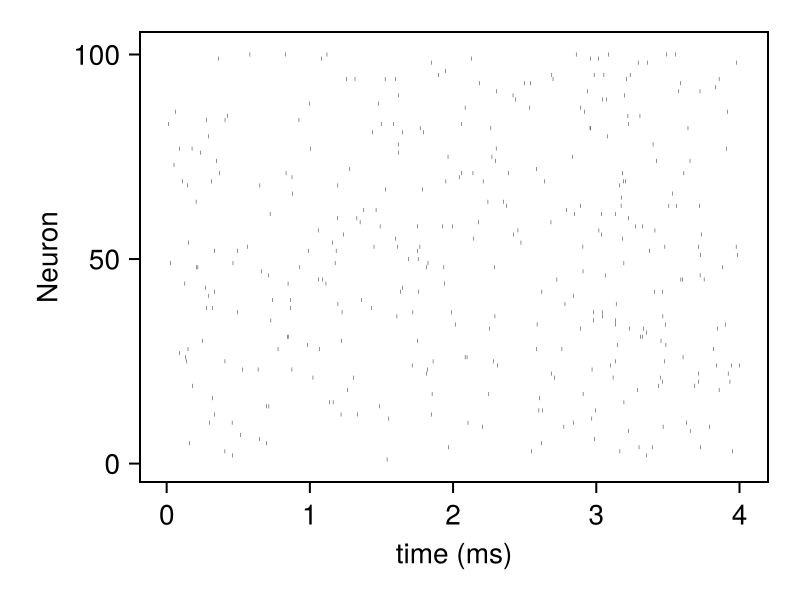

In [42]:
# spike rater plot
fig = Figure(size = (400, 300))
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "Neuron", xgridvisible = false, ygridvisible = false)
ap_dur = 0.003 # s (duration of action potential about 1ms)
t_0 = 5
t_end = 9
for i in 1:N
    for t_ in spikes[i]
        if t_0  < t_ < t_end
            ts = t_:dt:t_+ap_dur
            band!(ts .- t_0, ones(length(ts))*(i-0.5), ones(length(ts))*(i+0.5), color = :black)
        end
    end
end
fig

Shannon entropy: 0.8031608547866956


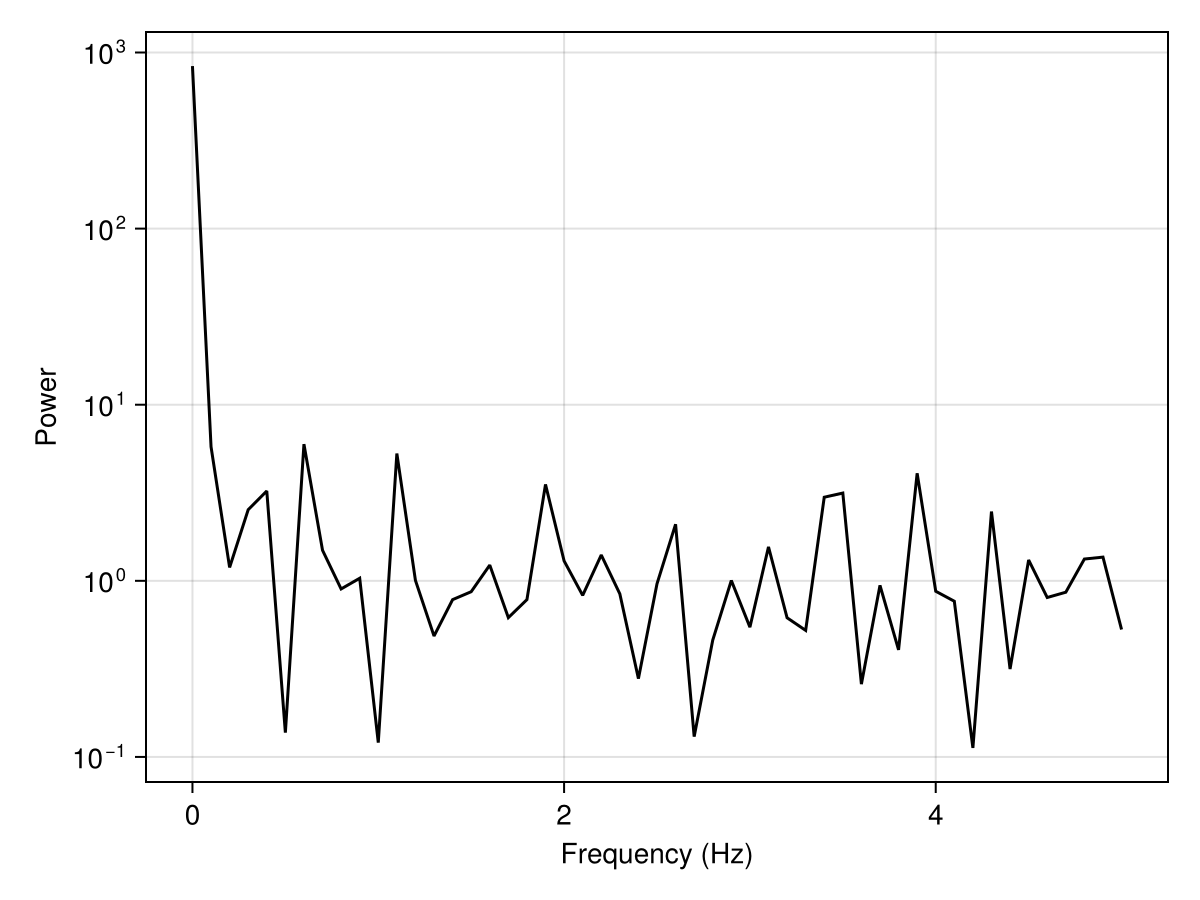

In [43]:
using DSP
# calculate entropy from the power spectrum of spike counts
bin = 0.1 # s
bins = 0:bin:t[end]
# last bin is always empty because no spike can happen after t[end]
spike_bins = collect(bins)[1:end-1]
spike_count = zeros(Int, length(bins)-1)
# sort spikes into bins
for i in 1:length(spikes)
    for t_ in spikes[i]
        bin_idx = findfirst(x -> x > t_, bins) - 1
        spike_count[bin_idx] += 1
    end
end

Pxx = periodogram(spike_count, fs=1/bin)
p = Pxx.power/ sum(Pxx.power)

# calculate entropy
H = -sum(p .* log2.(p))
print("Shannon entropy: $H\n")
fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "Frequency (Hz)", ylabel = "Power", yscale=log10)
lines!(ax, Pxx.freq, Pxx.power, color = :black)
fig


Shannon Entropy (measured): 2.3221073484488333


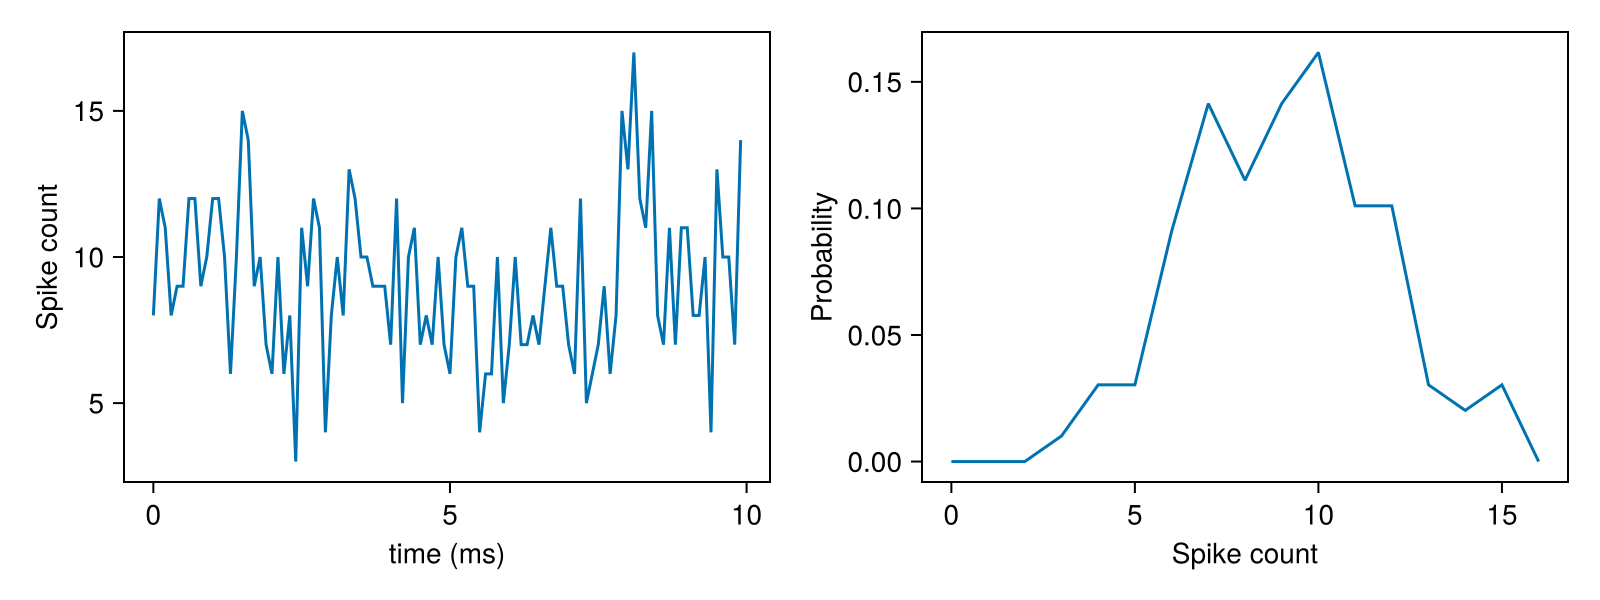

In [44]:
# calculate the entropy of the signal (makes no sense from the counting of spikes)
bin = 0.1 # s
bins = 0:bin:t[end]
# last bin is always empty because no spike can happen after t[end]
spike_bins = collect(bins)[1:end-1]
spike_count = zeros(Int, length(bins)-1)
# sort spikes into bins
for i in 1:length(spikes)
    for t_ in spikes[i]
        bin_idx = findfirst(x -> x > t_, bins) - 1
        spike_count[bin_idx] += 1
    end
end
# calculate the entropy from the probabiluty distribution of spike counts
# make histogram of spike counts
dist_count = normalize(fit(Histogram, spike_count, 0:1:maximum(spike_count)), mode = :probability)
H = 0
for i in 1:length(dist_count.weights)
    p = dist_count.weights[i]
    if p > 0
        H += -p * log(p)
    end
end
print("Shannon Entropy (measured): ", H, "\n")

fig = Figure(size = (800, 300))
# plot the spike count over time
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "Spike count", xgridvisible = false, ygridvisible = false)
lines!(ax, spike_bins, spike_count)
# plot the histogram
ax = Axis(fig[1, 2]; xlabel = "Spike count", ylabel = "Probability", xgridvisible = false, ygridvisible = false)
lines!(ax, dist_count.edges[1][1:end-1], dist_count.weights)
fig
